In [5]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from IPython.display import display
%reload_ext autoreload
%autoreload 2

import shutil
usetex = True if shutil.which('latex') else False
print("found latex:", usetex)
plt.rcParams.update({
    "text.usetex": usetex,
    "font.family": "DejaVu Sans",
    "font.size": 12,
})
plt.rc('text.latex', preamble=r'\usepackage{bm}')
figsize = 7

#%matplotlib notebook
%matplotlib inline

from lifters.plotting_tools import *

#df = pd.read_pickle("../_results/study_stereo1d_zero_noise.pkl")
import sys
sys.path.append("../_scripts/")
from noise_study import NOISE_DICT

found latex: True


# Constraints study

In [26]:
df = pd.read_pickle("../_results/constraints_big_stereo2d_urT.pkl")
df

,shuffle_seed,random_noise_seed,dual_cost,qcqp_cost,method,gap,rank,costs,num_constraints,lamda,...,A61:learned,A63:learned,A100:learned,A68:learned,A89:learned,A84:learned,A71:learned,A64:learned,A72:learned,A75:learned
0,-1,0,0.000151,0.000151,bnb,-2.148250e-09,19,"{1: 6.096983761373825e-11, 2: 0, 3: 0, 4: 0, 5...",19,"[0.0014759220579879185, 0.001381209825925364, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,0,0.000151,0.000151,all,-2.148250e-09,19,"{1: 6.096983761373825e-11, 2: 1.20815042493657...",19,"[0.0014759220579879185, 0.001381209825925364, ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,0.000151,0.000151,bnb,-4.676210e-09,19,"{1: 2.753612133940078e-09, 2: 0, 3: 0, 4: 0, 5...",51,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,0.000151,0.000151,all,-4.676210e-09,19,"{1: 2.753612133940078e-09, 2: 9.22349702487378...",51,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,0,0.000151,0.000151,bnb,-2.134796e-09,19,"{1: 2.753609465997473e-09, 2: 0, 3: 0, 4: 0, 5...",99,None,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN
5,1,0,0.000151,0.000151,all,-2.134796e-09,19,"{1: 2.753609465997473e-09, 2: 3.46908889530133...",99,None,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN
6,2,0,0.000151,0.000151,bnb,-1.540230e-09,19,"{1: 1.492915842021184e-10, 2: 0, 3: 0, 4: 0, 5...",94,None,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,2,0,0.000151,0.000151,all,-1.540230e-09,19,"{1: 1.492915842021184e-10, 2: 8.98216985037968...",94,None,...,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,-1,1,0.000404,0.000404,bnb,-1.213368e-09,19,"{1: 3.5706557135977434e-09, 2: 0, 3: 0, 4: 0, ...",18,"[0.0024074794938012223, 0.0022597338249771303,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,-1,1,0.000404,0.000404,all,-1.213368e-09,19,"{1: 3.5706557135977434e-09, 2: 1.2351803989493...",18,"[0.0024074794938012223, 0.0022597338249771303,...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


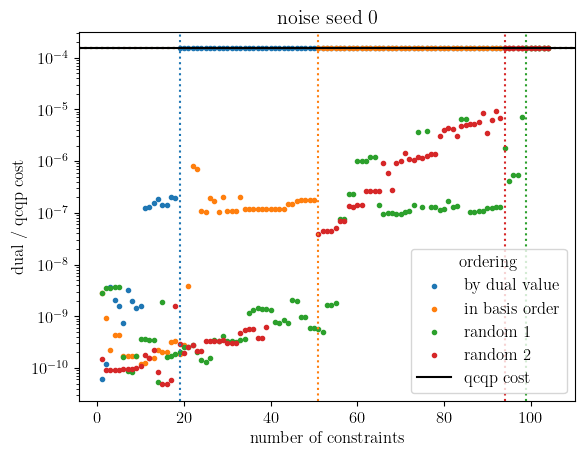

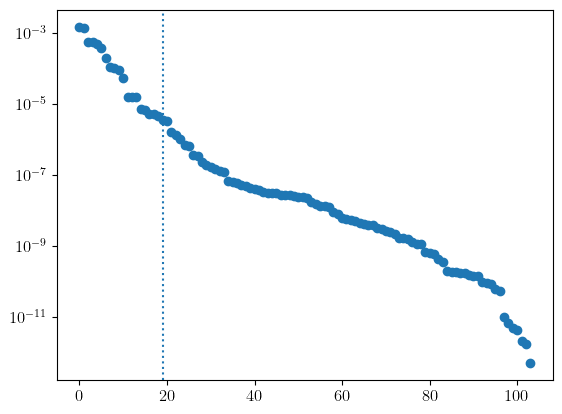

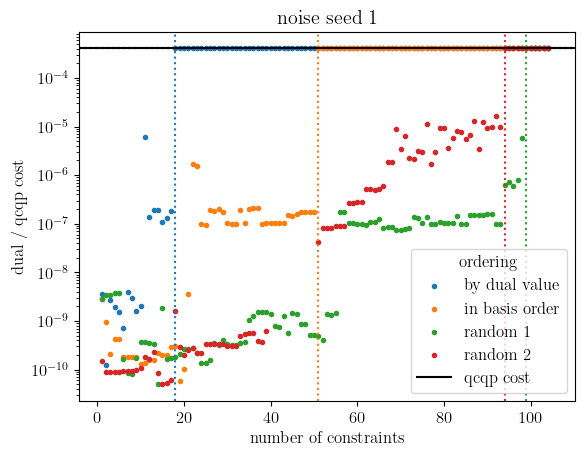

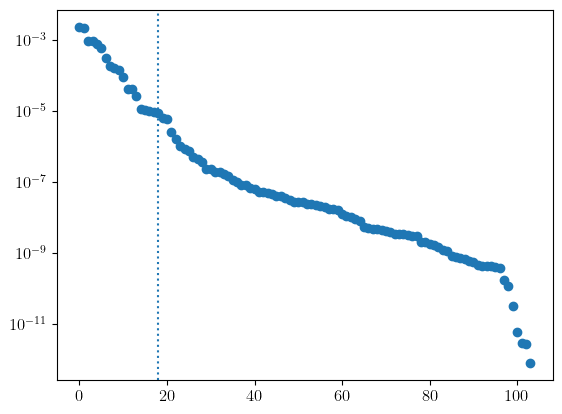

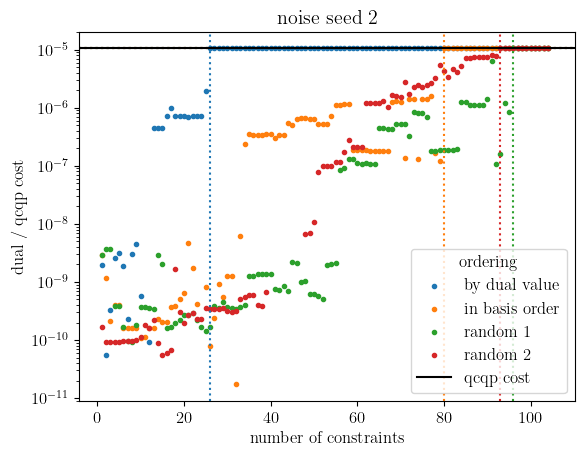

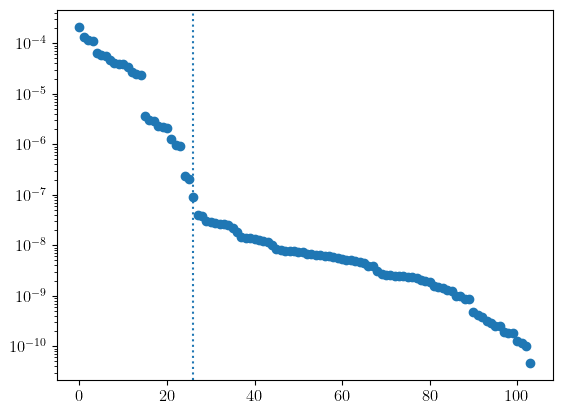

In [31]:
markers = {"all": ".", "bnb": "x"}
shuffle_names = {-1: "by dual value", 0:"in basis order"}
shuffle_names.update({i: f"random {i}" for i in range(1, 10)})
for seed, df_sub in df.groupby("random_noise_seed"):
    fig, ax = plt.subplots()
    ax.set_title(f"noise seed {seed}")
    for (method, shuffle), df_row in df_sub.groupby(["method","shuffle_seed"]):
        if method == "bnb":
            continue
            
        color = f"C{shuffle+1}"
        assert len(df_row) == 1
        row = df_row.iloc[0]
        ax.scatter(row.costs.keys(), 
                    row.costs.values(),
                    color=color, 
                    marker=markers[method],
                    label=shuffle_names[shuffle])
        ax.axvline(row.num_constraints, 
                    ls=":", 
                    color=color) 
        ax.axhline(row.dual_cost, ls=":", color=color)
        
        if (shuffle == -1) and (method == "all"):
            fig2, ax2 = plt.subplots()
            ax2.scatter(range(len(row.lamda)), np.abs(row.lamda), color=color)
            ax2.set_yscale("log")
            ax2.axvline(row.num_constraints, ls=":", color=color)
    ax.axhline(row.qcqp_cost, ls="-", color="k", label="qcqp cost")
    ax.set_yscale("log")
    ax.set_xlabel("number of constraints")
    ax.set_ylabel("dual / qcqp cost")
    ax.legend(title="ordering")

# Noise study

In [ ]:
# just one noise

import itertools

d_list = [2, 3]

noise = 0
lifter_types = ["slam1", "slam2"]
appendix = ""#"_sparse"
for d, lifter_type in itertools.product(d_list, lifter_types):
        
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 3)
    fig.suptitle(f"{d}d range {lifter_type}", y=1.0)
    name = f"study_range{lifter_type}_{d}d_{noise}noise{appendix}"
    try:
        fname = f"../_results/{name}.pkl"
        df = pd.read_pickle(fname)
    except:
        print("didn't find", fname)
        print(f"no results yet for {name} (looked at {fname})")
        continue

    if len(df) == 0:
        print(f"no data for {name}")
        continue
    df["dual cost"] = df["dual cost"].abs()

    plot_tightness(df, ax=ax)
    ax.legend([])
    ax.set_title(f"noise {NOISE_DICT[noise]:.0g}")
    ax.set_xlabel("constraints added")
    savefig(fig, f"../_plots/study_range{lifter_type}_{d}d_noise{appendix}.png")

In [ ]:
import itertools

d_list = [2, 3]
#d_list = [3]
noise_list = list(NOISE_DICT.keys())[:5]
lifter_types = ["slam1"]
for d, lifter_type in itertools.product(d_list, lifter_types):
        
    fig, axs = plt.subplots(1, len(noise_list), sharey=True, sharex=True, squeeze=False)
    axs = axs.flatten()
    fig.set_size_inches(len(noise_list)*3, 3)
    fig.suptitle(f"{d}d range {lifter_type}", y=1.0)
    for ax, noise in zip(axs, noise_list):
    
        name = f"study_range{lifter_type}_{d}d_{noise}noise"
        try:
            fname = f"../_results/{name}.pkl"
            df = pd.read_pickle(fname)
        except:
            print("didn't find", fname)
            print(f"no results yet for {name}")
            continue
            
        if len(df) == 0:
            print(f"no data for {name}")
            continue

        plot_tightness(df, ax=ax)
        ax.legend([])
        ax.set_title(f"noise {NOISE_DICT[noise]:.0g}")
        ax.set_xlabel("constraints added")
    savefig(fig, f"../_plots/study_range{lifter_type}_{d}d_noise.png")

In [ ]:
#df = pd.read_pickle("../_results/study_stereo1d_zero_noise.pkl")
import sys
sys.path.append("../_scripts/")
from noise_study import NOISE_DICT

import itertools

d_list = [1, 2, 3]
#d_list = [3]
noise_list = list(NOISE_DICT.keys())[:5]
level_list = ["no", "urT"]
for d, level in itertools.product(d_list, level_list):
    if d in [1] and level == "urT":
        continue
        
    fig, axs = plt.subplots(1, len(noise_list), sharey=True, sharex=True, squeeze=False)
    axs = axs.flatten()
    fig.set_size_inches(len(noise_list)*3, 3)
    fig.suptitle(f"{d}d stereo, Lassere level {level}", y=1.0)
    for ax, noise in zip(axs, noise_list):
    
        name = f"study_stereo{d}d_{noise}noise_{level}level"
        try:
            fname = f"../_results/{name}.pkl"
            df = pd.read_pickle(fname)
            print("read", fname)
        except:
            print("didn't find", fname)
            print(f"no results yet for {name}")
            continue
            
        if len(df) == 0:
            print(f"no data for {name}")
            continue

        plot_tightness(df, ax=ax)
        ax.legend([])
        ax.set_title(f"noise {NOISE_DICT[noise]:.0g}")
        ax.set_xlabel("constraints added")
    
    
    savefig(fig, f"../_plots/study_stereo{d}d_noise_{level}.png")

# Scaling study

In [ ]:
def poly_label(coeffs, xlabel="x"):
    label = ""
    for i, c in enumerate(coeffs):
        deg = len(coeffs) - i
        if deg > 1:
            if abs(c) > 1e-10:
                label += f"{c:.1f}${xlabel}^{deg}$ + "
        elif deg == 1:
            if abs(c) > 1e-10:
                label += f"{c:.1f}${xlabel}$ + "
        else:
            label += f"{c:.1f}"
    return label

In [ ]:
from scipy.optimize import curve_fit
from lifters.plotting_tools import savefig

plot_labels = ["variables", "redundant constraints", "moment constraints", "total constraints"]
groupby = ["d"]
x_name = "landmarks"
x_label = "K"

for name, level in zip(["stereo_study", "stereo_study_lasserre"],
                       ["no", "urT"]):
    df = pd.read_pickle(f"../_results/{name}.pkl") # added extra constraints

    df["total constraints"] = df["found"]
    df["moment constraints"] = df["substitutions"]
    df["redundant constraints"] = df["total constraints"] - df["moment constraints"]
    df.drop(["found", "substitutions", "known"], axis=1, inplace=True)

    #display(df)
    
    for group, df_group in df.groupby(groupby):
        #display(df_group)
        x = df_group[x_name].unique()

        fig, ax = plt.subplots()
        for i, label in enumerate(plot_labels):
            y = np.r_[df_group[label]]
            ax.plot(x, y, label=label, color=f"C{i+1}")

            coeffs = np.polyfit(x, y, 2)
            #coeffs = np.round(coeffs, 0)
            poly = np.poly1d(coeffs)
            label= poly_label(poly, xlabel=x_label) #f"{coeffs[0]:.1f}$x^2$ + {coeffs[1]:.1f}$x$ + {coeffs[2]:.1f}"
            ax.plot(x, poly(x), label=label, ls="", marker='o', color=f"C{i+1}")
        ax.legend(loc="upper left")
        ax.set_xlabel(f"{x_name} ${x_label}$")
        ax.set_xticks(x)
        dim=','.join([f"{v}{k}" for k, v in zip(groupby, [group])])
        title=f"{dim} with {level} Lasserre"
        ax.set_title(title)
        ax.grid()
        savefig(fig, f"../_plots/study_stereo{dim}_{level}.png")

# Next experiments